In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Wed Dec 16 09:29:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
class ChannelSELayer(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        B, C, H, W = input_tensor.size()
        squeeze_tensor = input_tensor.view(B, C, -1).mean(dim=2)
        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))
        output_tensor = torch.mul(input_tensor, fc_out_2.view(B, C, 1, 1))
        return output_tensor

class DepSepConv2d(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(DepSepConv2d, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=nin)
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DecResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Conv2d(in_channels=channels, out_channels=2 * channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d(2 * channels),
            nn.Hardswish(),
            DepSepConv2d(2 * channels, 3, 2 * channels),
            nn.BatchNorm2d(2 * channels),
            nn.Hardswish(),
            nn.Conv2d(in_channels=2 * channels, out_channels=channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            ChannelSELayer(channels)
        )

    def forward(self, x):
        return x + self.net(x)


class EncResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Hardswish(),
            nn.Conv2d(in_channels=channels, out_channels=2 * channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(2 * channels),
            nn.Hardswish(),
            nn.Conv2d(in_channels=2 * channels, out_channels=channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ChannelSELayer(channels)
        )

    def forward(self, x):
        return x + self.net(x)


In [14]:
class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        dataset1 = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               download=True)

        dataset2 = datasets.MNIST(root='./mnist_data/',
                                    train=False,
                                    download=True)

        self.data = torch.cat([dataset1.data, dataset2.data], dim=0).reshape(-1, 1, 28, 28).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

In [15]:
class VQ2d(nn.Module):
    def __init__(self, num_codes, code_size):
        super(VQ2d, self).__init__()
        self.code_size = code_size
        self.num_codes = num_codes
        self.codebook = nn.Parameter((torch.rand(num_codes, code_size) - 0.5) / num_codes)

    def to_indices(self, x): #[B, D, H, W]
        x = x.permute(0, 2, 3, 1).contiguous() #[B, H, W, D]
        x = x.view(len(x), -1, self.code_size) #[B, H*W, D]
        x_sq = torch.sum(x**2, dim=2, keepdim=True) #[B, H*W, 1]
        xy = torch.matmul(x, self.codebook.t())     #[B, H*W, K]
        y_sq = torch.sum(self.codebook**2, dim=1) #[K]
        distances = (x_sq - 2 * xy) + y_sq #[B, H*W, K]
        return torch.argmin(distances, dim=2) #[B, H*W]


    def forward(self, x, show_freq=False):
        bchw = x.shape
        encoding_indices = self.to_indices(x) #[B, H*W]
        quantized = self.codebook[encoding_indices, :] #[B, H*W, D]
        quantized = quantized.reshape(bchw[0], bchw[2], bchw[3], bchw[1]) #[B, H, W, D]
        quantized = quantized.permute(0, 3, 1, 2).contiguous() #[B, D, H, W]

        if show_freq: # record the selected frequency of each codes
            count = [0] * self.codebook.shape[0]
            for idx in encoding_indices.view(-1):
                count[idx] += 1
            return quantized, count
        else :
            return quantized


In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        )

        self.res1 = EncResBlock(128)

        self.res2 = EncResBlock(128)
        
        self.pixel_dense = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.res1(x)
        x = self.res2(x)
        return self.pixel_dense(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,  stride=1, padding=1)
        self.res1 = DecResBlock(128)

        self.res2 = DecResBlock(128)

        self.convT = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64,  out_channels=1, kernel_size=4, stride=2, padding=1)
        )


    def forward(self, x):
        x = self.conv(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.convT(x)
        return torch.sigmoid(x)

In [17]:
E = Encoder().to(device)
D = Decoder().to(device)

code_dim = 64
num_code = 64
vq = VQ2d(num_code, code_dim).to(device)
solver = optim.Adam(list(E.parameters()) + list(D.parameters()) + list(vq.parameters()), lr=1e-3, amsgrad=False)

mbsz = 256
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [18]:
num_epochs = 10
LOSS = []
reconstruction = []
pz_entropy = []
for epoch in range(num_epochs):
    for x in loader:
        x = x.to(device)
        solver.zero_grad()
        z_e = E(x)
        e, freq = vq(z_e, show_freq=True)
        x_q = D(z_e + (e - z_e).detach())
        commitme_loss = F.mse_loss(e.detach(), z_e)
        codebook_loss = F.mse_loss(e, z_e.detach())
        reconstr_loss = F.binary_cross_entropy(x_q, x)
        loss = reconstr_loss + codebook_loss + 0.25 * commitme_loss
        loss.backward()
        solver.step()

        reconstruction.append(reconstr_loss.item())

        freq = np.array(freq, dtype=np.float)
        pz = freq / freq.sum()
        z_entropy = -(pz * np.log(pz + 1e-8)).sum()
        pz_entropy.append(z_entropy)
    print('epoch:', epoch, 'recon:', reconstruction[-1], 'entropy', pz_entropy[-1])


epoch: 0 recon: 0.08751959353685379 entropy 2.9053697173589605
epoch: 1 recon: 0.0801573395729065 entropy 3.422013221123331
epoch: 2 recon: 0.07282163202762604 entropy 3.541809778332892
epoch: 3 recon: 0.07246647775173187 entropy 3.6822564180023436
epoch: 4 recon: 0.07006560266017914 entropy 3.759613304113922
epoch: 5 recon: 0.06827256828546524 entropy 3.7708413982378692
epoch: 6 recon: 0.06873303651809692 entropy 3.76767208776823
epoch: 7 recon: 0.06621725857257843 entropy 3.7575079836851653
epoch: 8 recon: 0.06763044744729996 entropy 3.798300180089851
epoch: 9 recon: 0.06810913980007172 entropy 3.8023199188817802


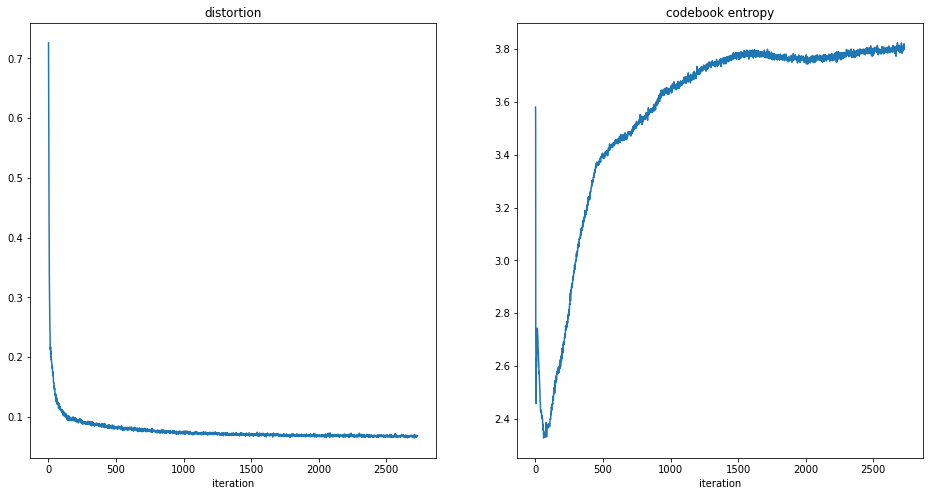

In [19]:

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(reconstruction) + 1), reconstruction)
ax.set_title('distortion')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(pz_entropy) + 1), pz_entropy)
ax.set_title('codebook entropy')
ax.set_xlabel('iteration')

plt.show()

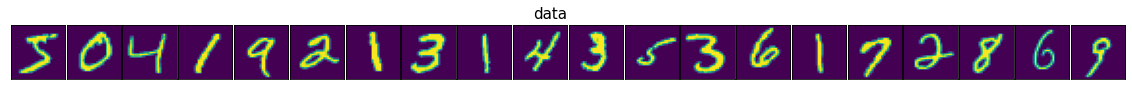

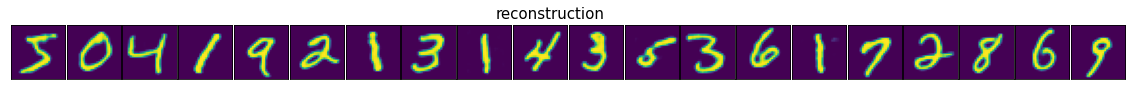

In [20]:
num_image = 20

fig = plt.figure(figsize=(20, 2))
n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(dataset.data[n].cpu().reshape(28, 28).numpy())
    n += 1
fig.suptitle('data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig = plt.figure(figsize=(20, 2))
n = 0
with torch.no_grad():
    for i in range(num_image):

        x = dataset.data[n].reshape(1, 1, 28, 28).to(device)
        z_e = E(x)
        e = vq(z_e)
        x_q = D(z_e + (e - z_e).detach())

        _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
        _fig.imshow(x_q.cpu().data.numpy().reshape(28, 28))
        n += 1
fig.suptitle('reconstruction', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()